<a href="https://colab.research.google.com/github/COGS108/Group065Sp22/blob/master/EDACheckpointGroup065Sp22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COGS 108 - EDA Checkpoint

# Names

- Zihan Chen
- Ning Ma
- Kancheng Yin
- Nan Jiang

<a id='research_question'></a>
# I. Research Question

**General question**: What makes an airplane crash more fatal? 


**Specific question**: 
1. Does the fatality (rate) associate with a specific time of the day and specific location of the world? 
2. Does the fatality (rate) associate with who's operataing the plane *(private vs. military personale)*?
3. Is there any keywords are more likely to associate with high fatality accident *(e.g., "birds", "air traffic", "operator errors")*?


# II. Setup

Load libraries

In [215]:
## library
# Import numpy to handle numerical information and analyse data
import numpy as np

# Import pandas to read csv file and to work with dataframes
import pandas as pd

# Import matplotlib and seaborn to visulize data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')

# Import math to perform mathematical operations
import math

# Import patsy and statsmodels to perform regression
import patsy
import statsmodels.api as sm

# New version of Statmodels & patsy
import statsmodels.formula.api as smf

# Import scipy to perform statistical operations
import scipy.stats as stats

# Set warnings to ignore
import warnings
warnings.filterwarnings('ignore')


#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

Load the data.

In [129]:
## Load data 
# Load the airplane crashes and fatalities data from 1908 to 2009
# We get this dataset from data.world(https://data.world/data-society/airplane-crashes)
df_main = pd.read_csv('data/Airplane_Crashes_and_Fatalities_From_1908_to_2009.csv')

# Load the supplimentary aviation accidents data from 1919 to 2022 which 
# we will only use data from 2009 to 2022
# We get this dataset from Kaggle(https://www.kaggle.com/datasets/ramjasmaurya/aviation-accidents-history1919-april-2022)
df_supplementary = pd.read_csv('data/supplementary_aviation_accidents.csv')

# III. Data Cleaning

### 3.1 First, we clean the airplane crash data


As mentioned before, 

**df_main** has columns `['Date', 'Time', 'Location', 'Operator', 'Flight #', 'Route', 'Type','Registration', 'cn/In', 'Aboard', 'Fatalities', 'Ground', 'Summary']` 
       
**df_supplementary** has columns `['Country', 'date', 'Air-craft type', 'registration name/mark', 'operator', 'fatilites', 'location', 'category']`

With our research problem, we only need `['Date', 'Location', 'Operator', 'Route', 'Type', 'Aboard', 'Fatalities', 'Summary']` columns. We will extract columns `['Country', 'date', 'Air-craft type', 'operator', 'fatilites', 'location']` from supplementary data and convert them so that two datasets have same format in same type of data. 

In [130]:
# This function is used to unify the date format to be year/month/day
def unify(data):
    data = str(data).split('/')
    if len(data) < 3:
        return ''
    return data[2] + '/' + data[0] + '/' + data[1]

# Remain the data that required by our research problem
columns_final = ['Date', 'Time', 'Location', 'Operator', 'Route', 'Type', 'Aboard', 'Fatalities', 'Summary']
df_main = df_main[columns_final]

# unify the date format
df_main['Date'] = df_main['Date'].apply(unify)

Then we will transform supplementary data to the format that main dataset requires.

In [131]:
import calendar
# Notice that month in this dataset is in string format, we need to convert it to number
month_to_number = {month: str(index) for index, month in enumerate(calendar.month_abbr) if month}
for month in month_to_number:
    if len(month_to_number[month]) == 1:
        month_to_number[month] = "0" + month_to_number[month]

# This function is used to unify the date format to be year/month/day for this dataset
def filter_date(data):
    if isinstance(data, float):
        return ''
    
    data = str(data).split('-')
    if len(data) < 3:
        return ''
    if data[1] in month_to_number:
        data[1] = month_to_number[data[1]]
    
    if data[1] == '???': 
        return '/'.join([data[2], '01/01'])
    elif data[0] == '??': 
        return '/'.join([data[2], data[1], '01'])
    elif len(data) == 3:
        return '/'.join([data[2], data[1], data[0]])
    else:
        return ''

# Notice that there are weird input for fatalities(e.g. 8+1)
# So this function is used to filter the fatalities data
def filter_fatalities(data):
    data = str(data)
    if "+" in data:
        return sum([int(x) for x in data.split('+')])
    else:
        return int(data) if data.isdigit() else 0

# This function is clean the data to the format that we need in order to append to main dataframe
def transform(df_supplementary):
    df_filtered = df_supplementary[['date', 'Country', 'location', 'operator', 'Air-craft type', 'fatilites']]

    # unify the name for the columns
    df_filtered = df_filtered.rename(columns={'date': 'Date', 'location': 'Location', 'operator': 'Operator', 
                                                'Air-craft type': 'Type', 'fatilites': 'Fatalities'})

    # append the country name to the location
    df_filtered['Location'] = df_filtered['Location'] + ", " + df_filtered['Country']

    # Replace "near" in the location because we will draw heatmap with this data
    df_filtered['Location'] = df_filtered['Location'].apply(lambda x: str(x).replace('near', ''))

    # filter the date with designed functions
    df_filtered['Date'] = df_filtered['Date'].apply(filter_date)
    df_filtered['Fatalities'] = df_filtered['Fatalities'].apply(filter_fatalities)
    
    return df_filtered.drop(columns=['Country'])

df_supplementary = transform(df_supplementary)


Since We just need data from 2009 to 2022, we will append only them to the main dataframe

In [132]:
# We will only use data from 2009 to 2022
df_supplementary = df_supplementary[pd.to_datetime(df_supplementary['Date']) > "01-Jan-2009"]

# Since there are three columns this dataframe does not have, so we need to add them
df_supplementary[['Route', 'Summary']] = " "
df_supplementary['Aboard'] = -1
df_supplementary['Time'] = np.nan

# Reorder the columns
df_supplementary = df_supplementary[['Date', 'Time', 'Location', 'Operator', 'Route', 'Type', 'Aboard', 'Fatalities', 'Summary']]

### 3.2 Second, we merge the data

Now we do the last cleaning which is removing airplane crash that does not have date andreplacing invalid value to default value

In [133]:
df = df_main.append(df_supplementary).reset_index(drop=True)

# free memory
del df_main
del df_supplementary

# We replace the empty data to NaN and drop rows with NaN date
for column in columns_final:
    df[column] = df[column].replace('', np.nan)
df.dropna(subset=['Date'])
df[['Aboard', 'Fatalities']] = df[['Aboard', 'Fatalities']].fillna(0)
# Change these two columns to int
df['Aboard'] = df['Aboard'].astype(int)
df['Fatalities'] = df['Fatalities'].astype(int)

# We save this dataframe to csv file for future use
df.to_csv('data/df.csv')

### 3.3 The Final DataFrame
- **Date:** The year/month/day of airplane crash
- **Location:** Location of the airplane crash
- **Operator:** The institute/company/government/office that operate the flight
- **Route:** The Route of the flight
- **Type:** Airplane type of the flight
- **Aboard:** Aboard number of the flight
- **Fatalities:** Fatalities of the airplane crash
- **Summary:** Brief summary for what causes this airplane crash

In [134]:
df.head()
# df.shape

,Date,Time,Location,Operator,Route,Type,Aboard,Fatalities,Summary
0,1908/09/17,17:18,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2,1,"During a demonstration flight, a U.S. Army fly..."
1,1912/07/12,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5,5,First U.S. dirigible Akron exploded just offsh...
2,1913/08/06,NaN,"Victoria, British Columbia, Canada",Private,NaN,Curtiss seaplane,1,1,The first fatal airplane accident in Canada oc...
3,1913/09/09,18:30,Over the North Sea,Military - German Navy,NaN,Zeppelin L-1 (airship),20,14,The airship flew into a thunderstorm and encou...
4,1913/10/17,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,Zeppelin L-2 (airship),30,30,Hydrogen gas which was being vented was sucked...


# IV. Data Analysis & Results (EDA)

## 4.1 Describe the data

In this section, we will visualize and summarize the distribution of each individual variable.


### 4.1.1 Variable `Date`

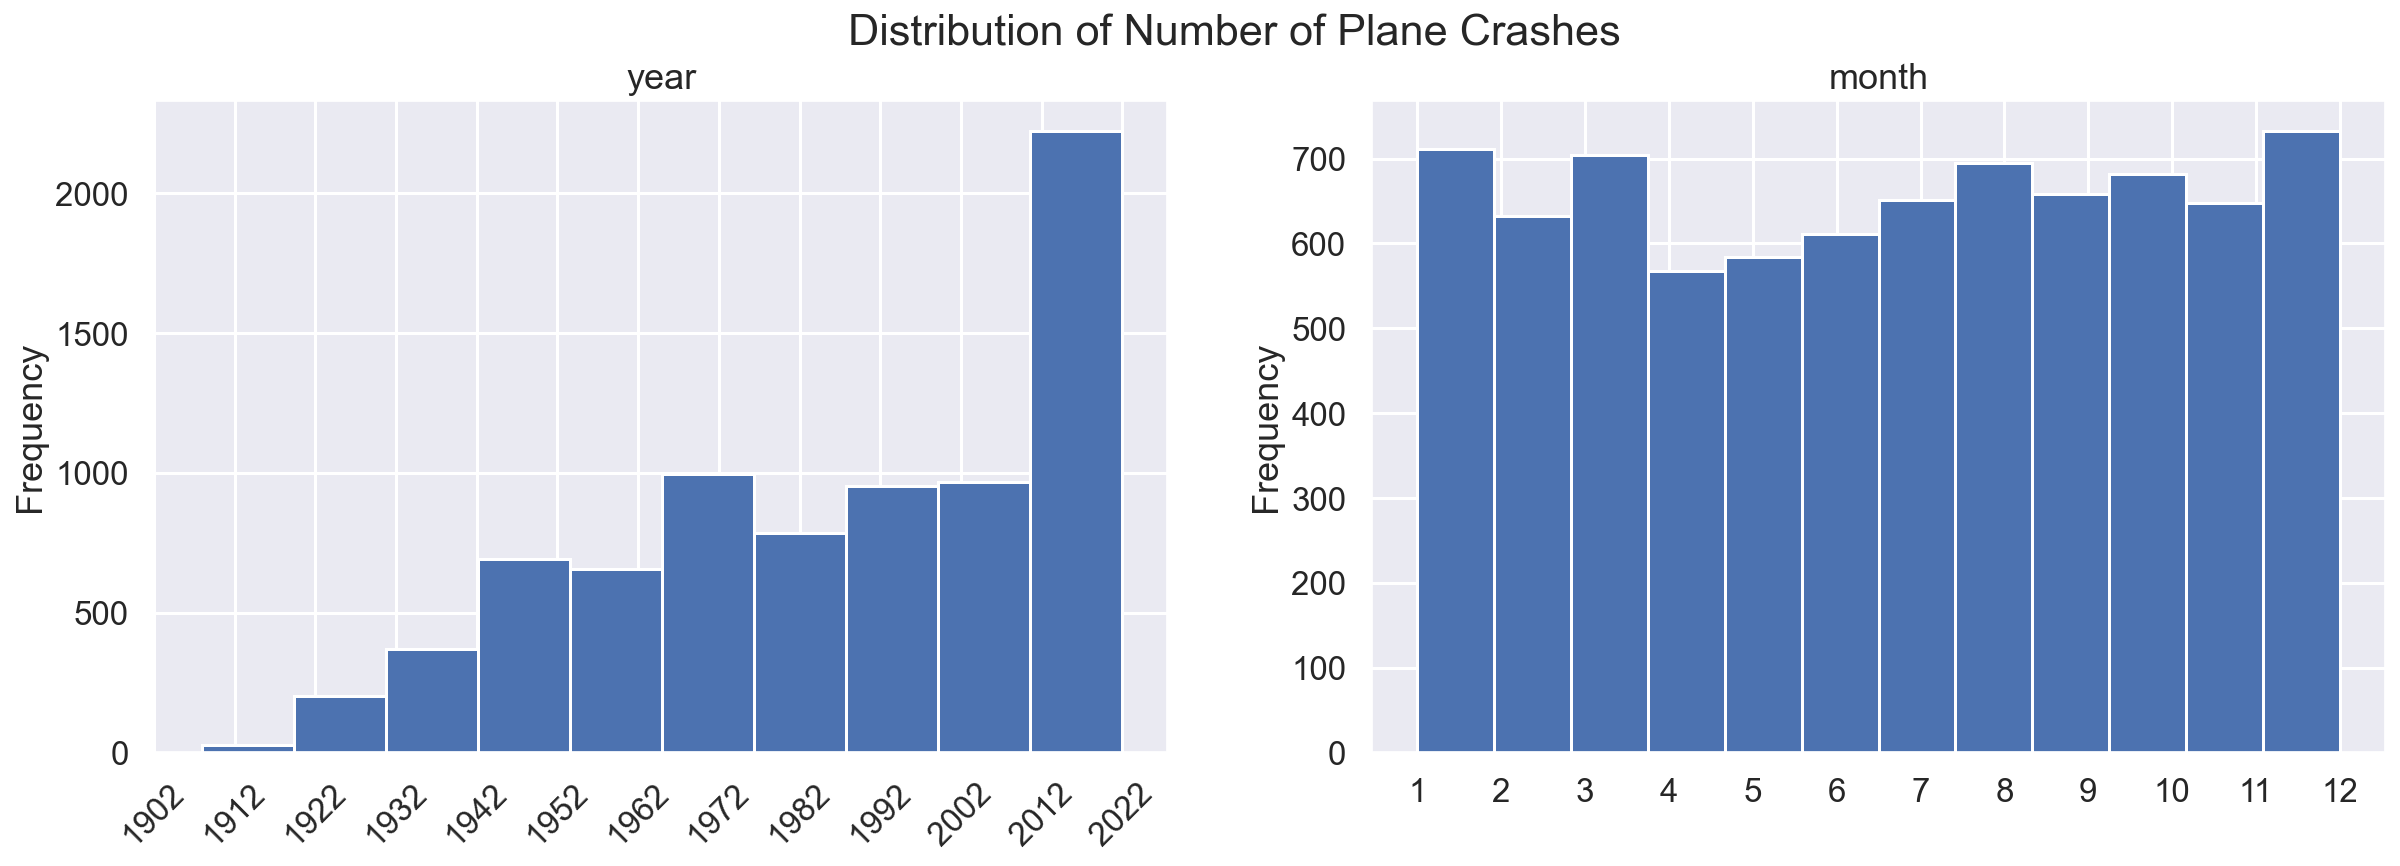

In [135]:
# Convert 'Date' datatype into datetime object
crash_date = pd.to_datetime(df['Date'])
fig, axes = plt.subplots(1, 2, figsize = (20,6))

# Plot the the number of plane crashes in each decade from 1902-2022
crash_year = crash_date.dt.year
crash_year.plot(kind = 'hist', ax = axes[0], rot = 45, title = 'year')
axes[0].set_xticks([1902 + 10 * x for x in range(13)]) 

# Plot the relation between the number of plane crashes in each month
crash_month = crash_date.dt.month
crash_month.plot(kind = 'hist', ax = axes[1], title = 'month', bins = 12)
axes[1].set_xticks([x for x in range(1,13)]) 

fig.suptitle('Distribution of Number of Plane Crashes')
plt.show()

- When we look at the distribution of plane crashes over the **years** (decades), we see that the histogram is left-skewed, where there is an **increasing** trend of the total number of plane crashes over the years. 
- For the number plane crashes in each **month**, we see that the distribution is nearly uniform.

### 4.1.2 Variable `Time`

In [136]:
df2 = df.copy()

In [137]:
def clean_time(str_in):
    str_in = str(str_in)
    if(len(str_in) != 5 or str_in[2] != ':'):
        return 'na'
    else:
        return str_in[0:2]

#clean the time columnn to remove incorrect and missing data
df2['Time'] = df2['Time'].apply(clean_time)
df2 = df2[df2['Time'] != 'na']
df2['Time'] = df2['Time'].astype(int)

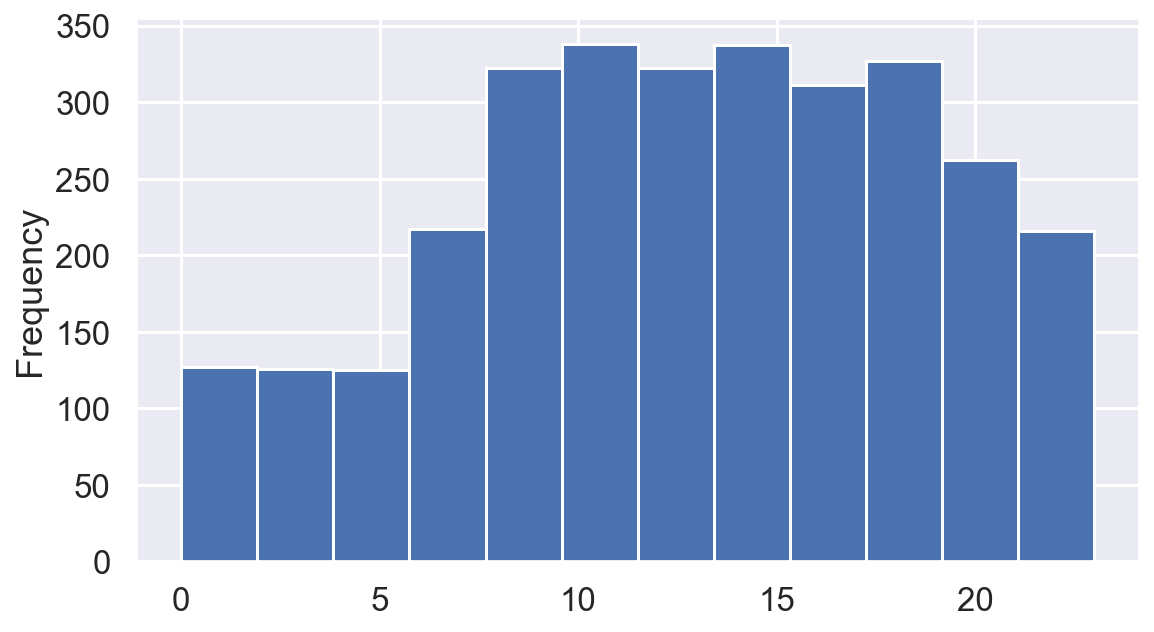

In [138]:
df2['Time'].plot(kind = 'hist', bins = 12, figsize = (9,5))
plt.show()

The data for time is skewed to the right, where plane crashes seems to happend more after 6 am

### 4.1.3 Variable `Location`

In [139]:
# Extract relavant data for plotting
loc = df['Location'].dropna()
all_loc = loc[loc.str.contains(',')].str.split(',').sum()
all_loc = pd.Series(all_loc)

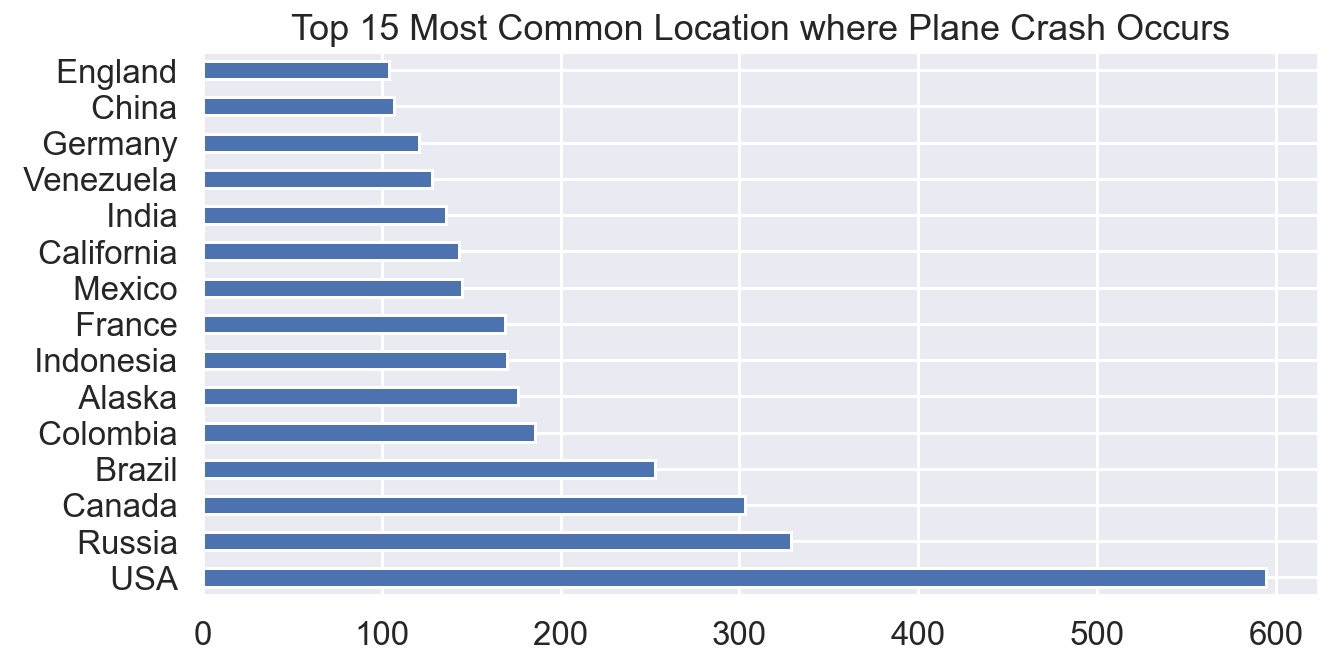

In [140]:
all_loc.value_counts()[:15].plot(kind = 'barh', 
                                  figsize = (10, 5), 
                                  title = 'Top 15 Most Common Location where Plane Crash Occurs')
plt.show()

### 4.1.4 Variable `Operator`

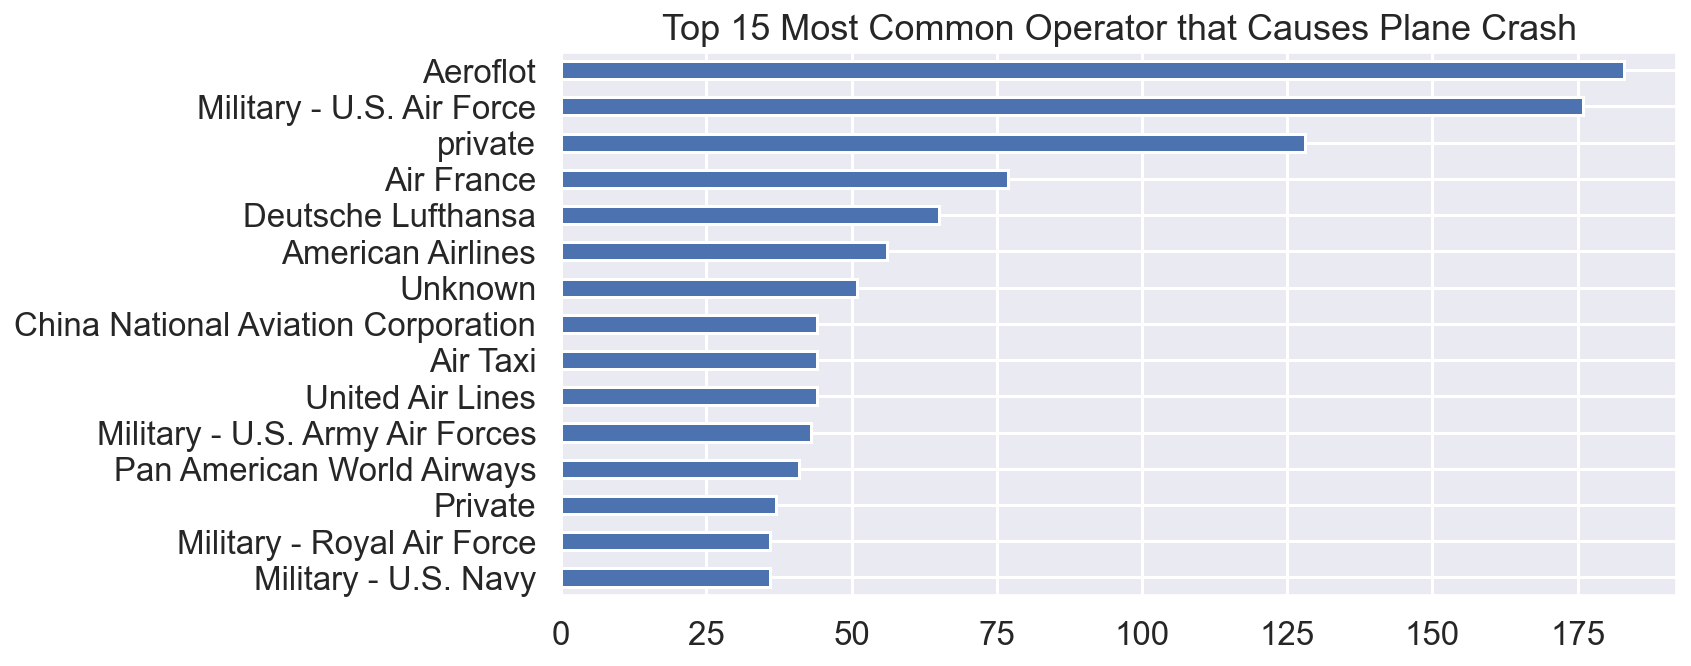

In [141]:
df['Operator'].value_counts(ascending = True)[-15:].plot(kind = 'barh', 
                                                         figsize = (10, 5), 
                                                         title = 'Top 15 Most Common Operator that Causes Plane Crash')
plt.show()

### 4.1.5 Variable `Route`

In [142]:
df['Route'].nunique(), df['Route'].unique()

(3245,
 array(['Demonstration', 'Test flight', nan, ...,
        'Lourdes de BlanSablon - Port Hope Simpson', 'Mechuka for Jorhat',
        ' '], dtype=object))

### 4.1.6 Variable `Type`

In [143]:
df['Type'].nunique(), df['Type'].unique()

(3166,
 array(['Wright Flyer III', 'Dirigible', 'Curtiss seaplane', ...,
        'Boeing 737-8GK (WL)', 'Embraer', 'Tupolev Tu-204-100'],
       dtype=object))

### 4.1.7 Variable `Aboard`

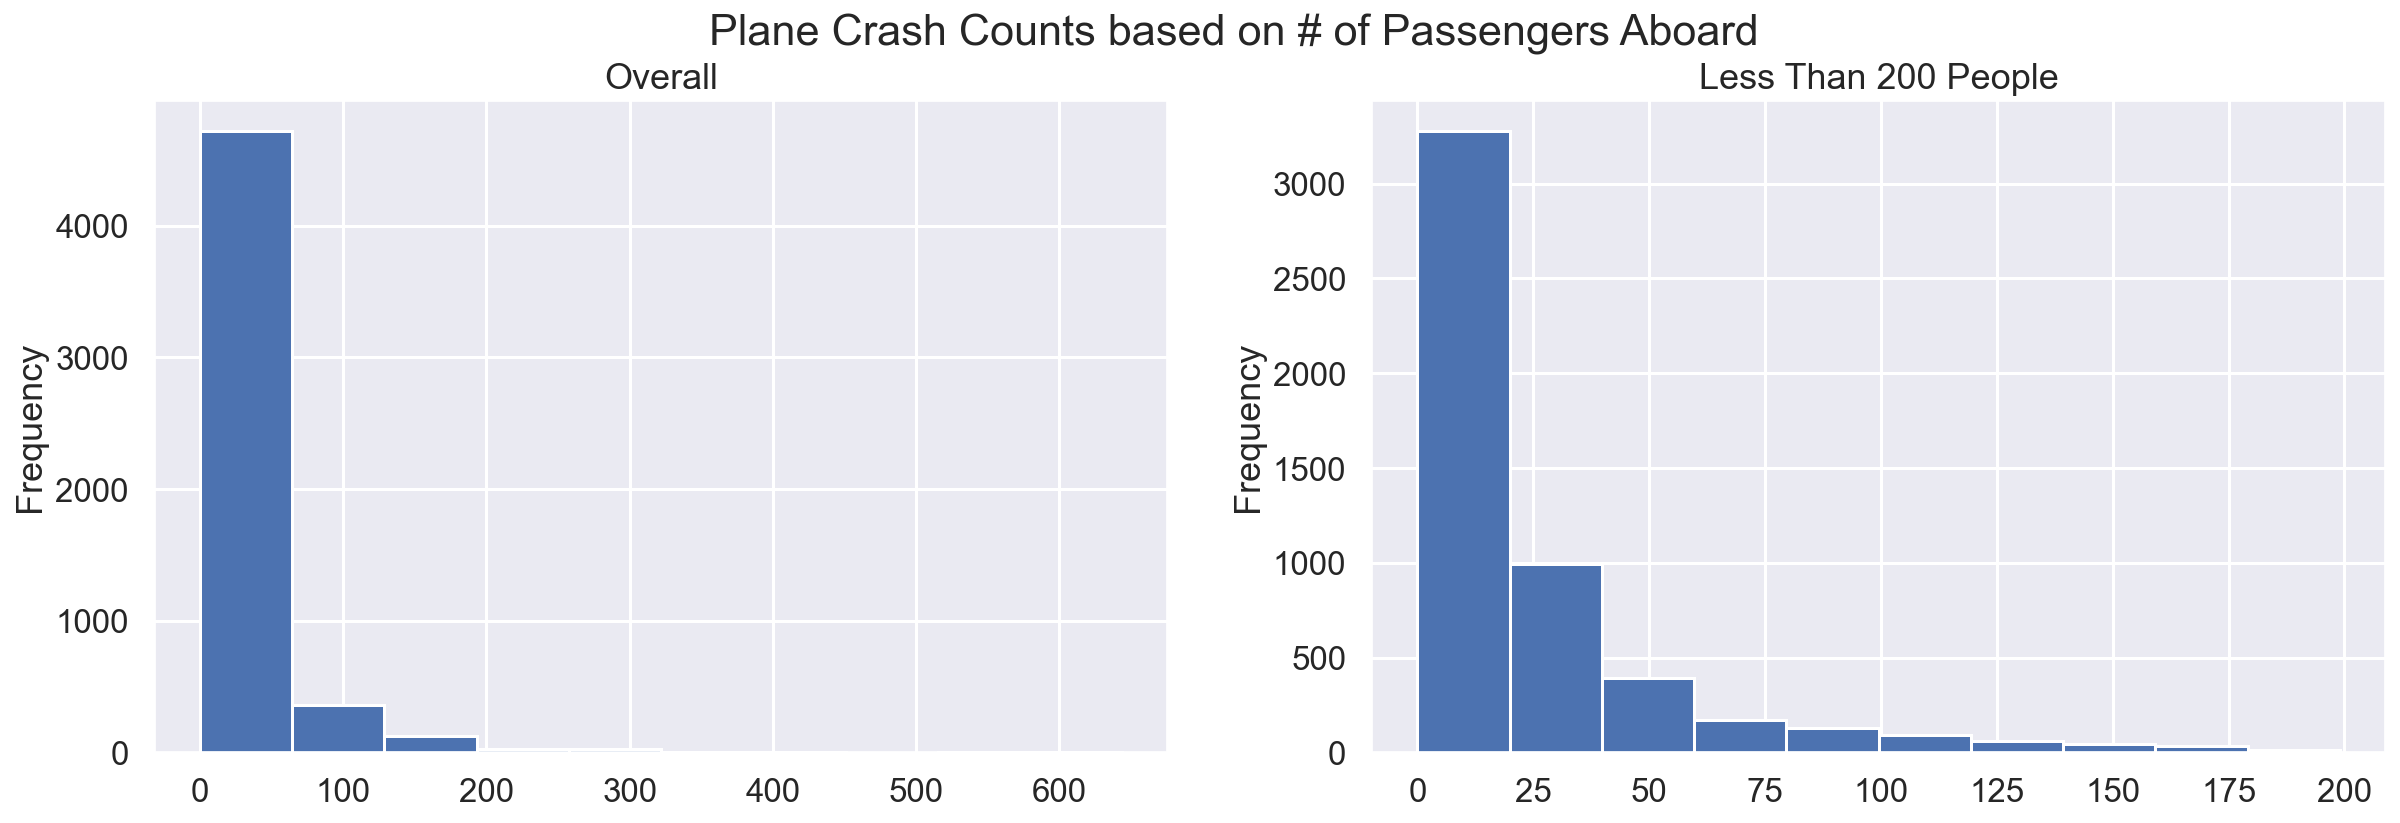

In [144]:
valid_aboard = df[df['Aboard'] >= 0]['Aboard']

fig, axes = plt.subplots(1, 2, figsize = (20,6))
valid_aboard.plot(kind = 'hist', ax = axes[0], title = 'Overall')
valid_aboard[valid_aboard < 200].plot(kind = 'hist', ax = axes[1], title = 'Less Than 200 People')
fig.suptitle('Plane Crash Counts based on # of Passengers Aboard')
plt.show()

The overall distribution is extremely right skewed, with the majority plane crashes happens in planes that have less than 75 people on board.

### 4.1.8 Variable `Fatalities`

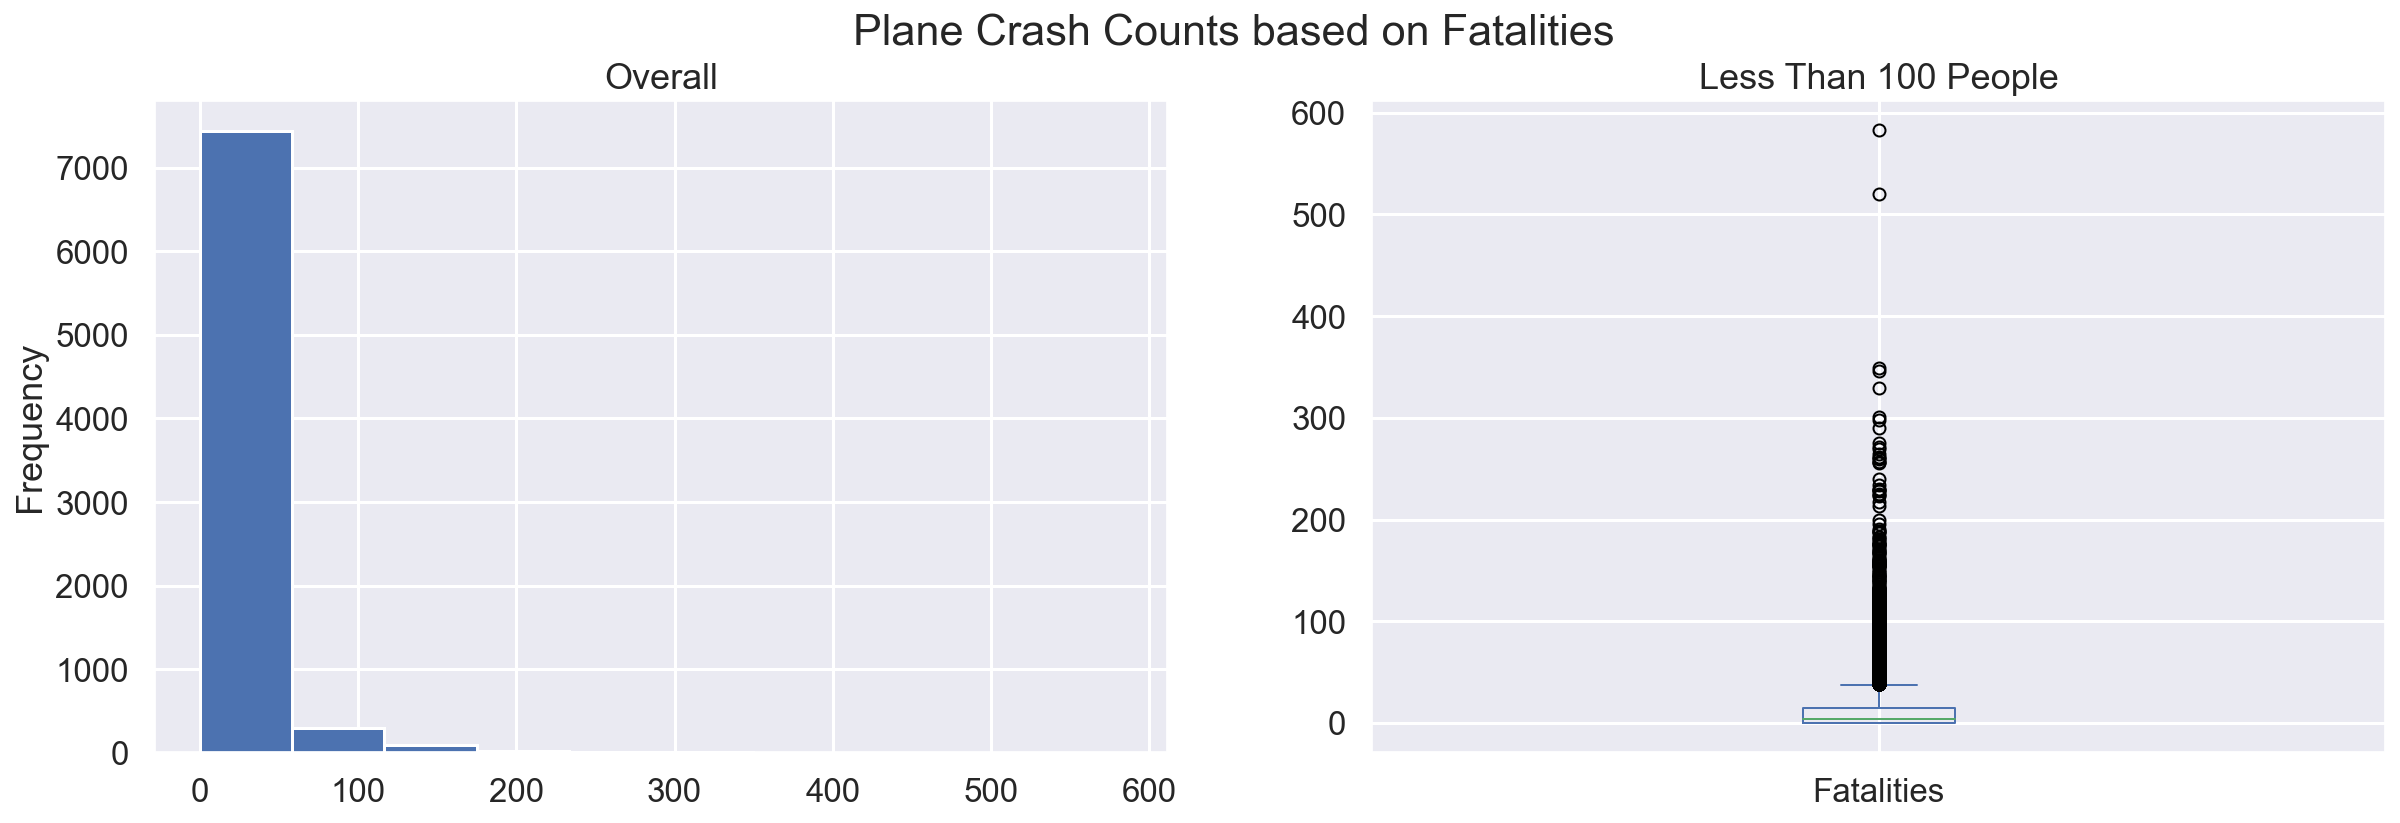

In [145]:
fatal = df['Fatalities']

fig, axes = plt.subplots(1, 2, figsize = (20,6))
fatal.plot(kind = 'hist', ax = axes[0], title = 'Overall')
fatal.plot(kind = 'box', ax = axes[1], title = 'Less Than 100 People')
fig.suptitle('Plane Crash Counts based on Fatalities')
plt.show()

s

## 4.2 What affects the airplane accidents' fatalities?


In [1]:
# set plotting size parameter
plt.rcParams['figure.figsize'] = (13, 6) #default plot size to output

NameError: name 'plt' is not defined

### 4.2.1 *Does the fatality associate with a specific time of the day?*


In [162]:
df2['Time'].value_counts();

In [163]:
df2 = df2.sort_values(by = 'Time', ascending = True)

Generate a graph showing the trend of fatalities over time 

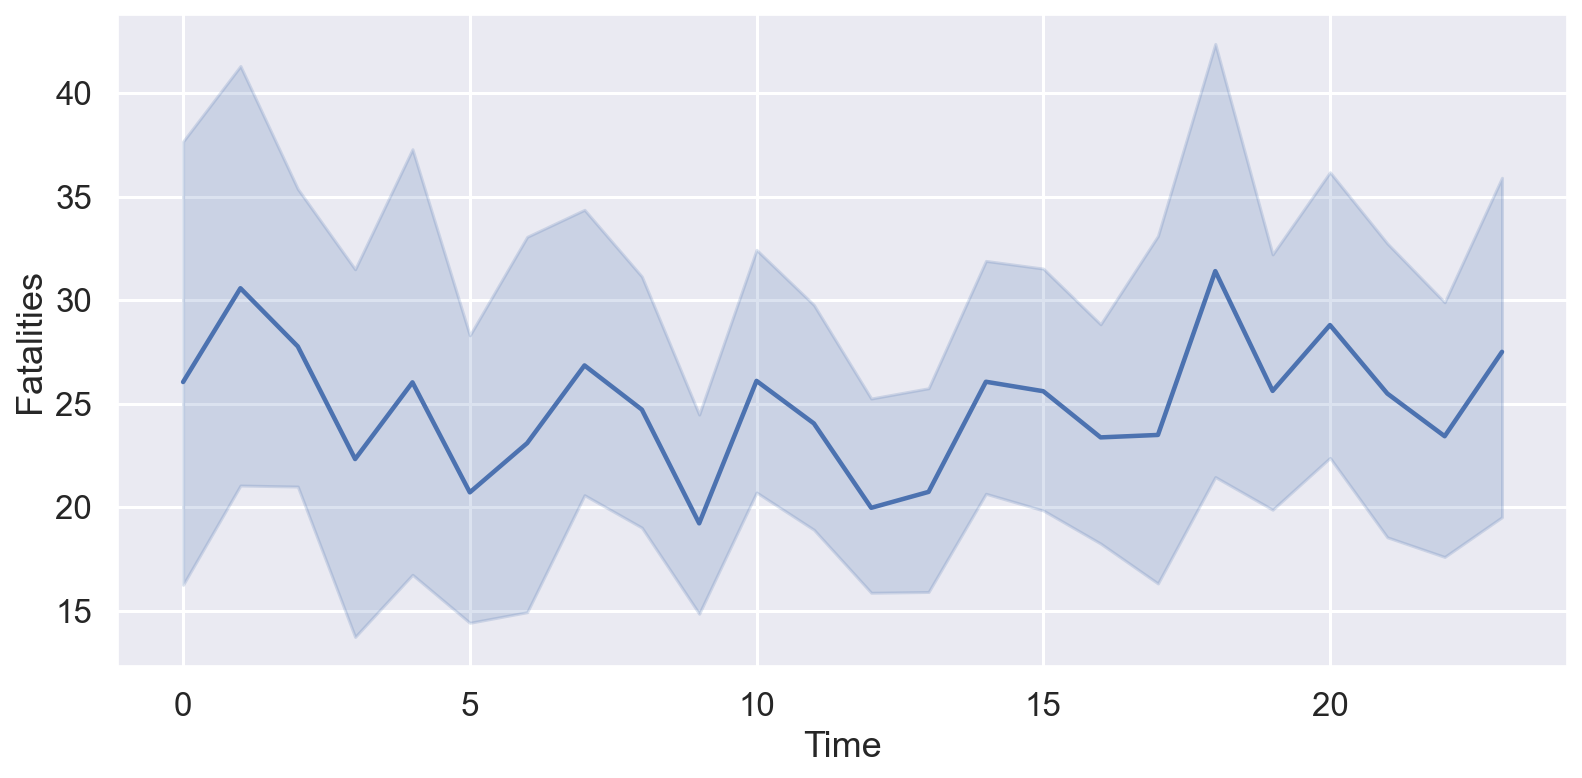

In [164]:
sns.lineplot(x = 'Time', y = 'Fatalities', data = df2);

In [165]:
df2.groupby('Time').mean();

In [166]:
def convert_time(time):
    if time in night:
        return 'night'
    else:
        return 'day'
    
df2['day/night'] = df2['Time'].apply(convert_time)

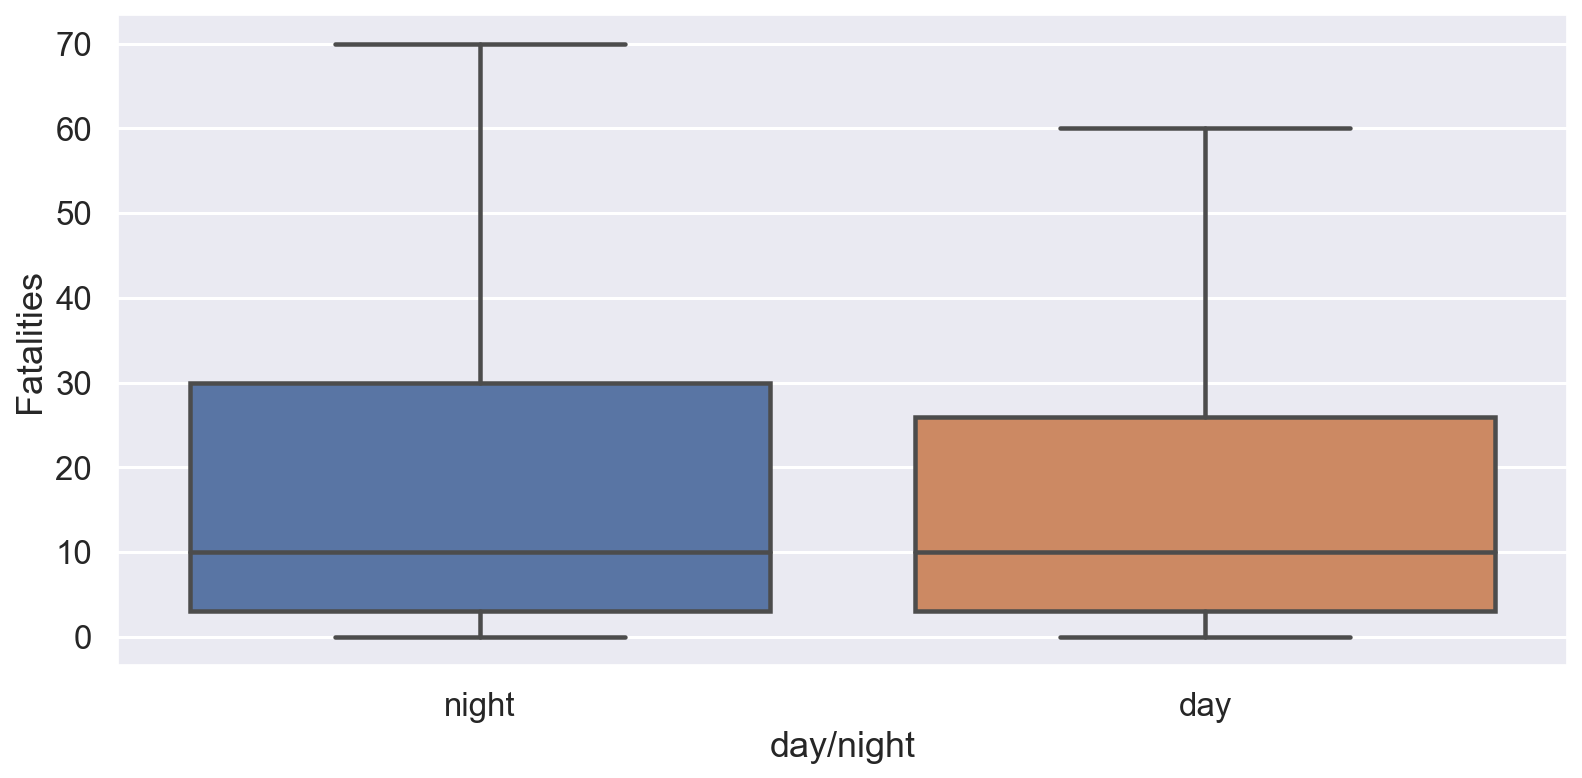

In [167]:
sns.boxplot(y='Fatalities', x='day/night', data=df2, showfliers = False);

- it seems like there might be a difference of fatality between the night and day condition, but outliers made it hard to tell by just looking at it.
- so we are going to perform t-test to test whether night lights and daytime flights have a difference. 

In [168]:
night = [18,19,20,21,22,23,0,1]
w_night = df2[df2['Time'].isin(night)]['Fatalities']
w_day = df2[df2['Time'].isin(night) == False]['Fatalities']

In [169]:
t_val, p_val = stats.ttest_ind(w_night, w_day)
t_val, p_val

(2.3306959027440857, 0.019834746121585072)

In [170]:
if p_val < 0.025:
    print('There is a significant difference!')
else:
    print('There is NOT a significant difference!')

There is a significant difference!


> we see that the flights at night generally have higher fatalities over flights at day time and we have two peek fatality time which is 18pm and 1am. 

### 4.2.2 *Does the fatality associated with a specific location in the world?*


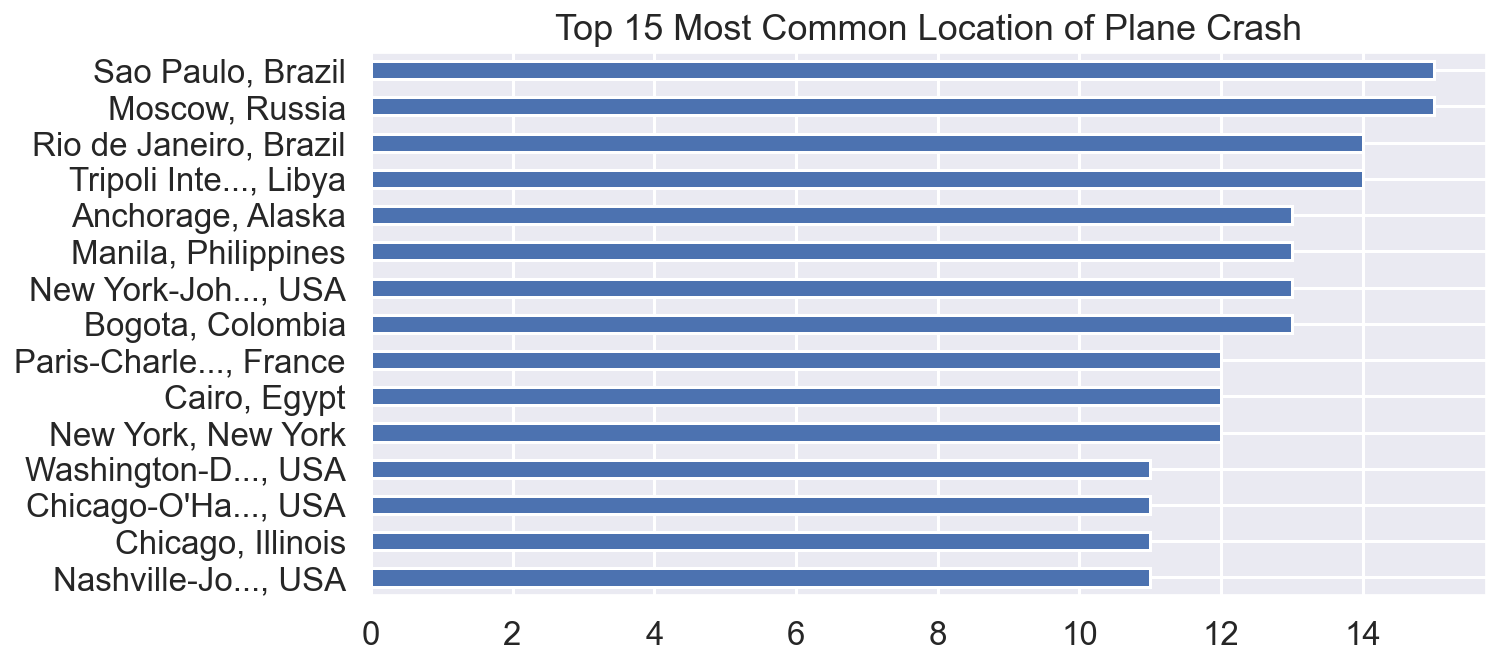

In [171]:
df['Location'].value_counts(ascending = True)[-15:].plot(kind = 'barh', 
                                                         figsize = (10, 5), 
                                                         title = 'Top 15 Most Common Location of Plane Crash')
plt.show()

In [172]:
df2.groupby('Location').mean()

,Time,Aboard,Fatalities
Location,,,
"100 miles SW of Kuujjuaq, Quebec, Canada",13.0,2.0,2.0
"110 miles SW of Sochi, Russia",13.0,78.0,78.0
"200 miles NE of Derby, Australia",10.0,4.0,4.0
"25 nm off Agrigento, Italy",4.0,26.0,26.0
"300 nm NW of San Francisco, California",10.0,274.0,0.0
...,...,...,...
"Zeya, Russia",20.0,34.0,3.0
"Zifta, Egypt",7.0,4.0,4.0
"Zurich, Switzerland",14.0,47.0,46.0


We notice that there are many detailed locations. So we currently just focus on country. We perform t-test to test whether certain countries will have different crash rate compared to other countries

In [173]:
countries_with_high_crash_rate = ['Brazil','Russia','USA']
l_high = df2[df2['Location'].str.contains('|'.join(countries_with_high_crash_rate), na=False)]['Fatalities']
l_other = df2[~df2['Location'].str.contains('|'.join(countries_with_high_crash_rate), na=False)]['Fatalities']

In [174]:
t_val, p_val = stats.ttest_ind(l_high, l_other)
t_val, p_val

(3.2861873025916224, 0.0010271157692308516)

In [175]:
if p_val < 0.025:
    print('There is a significant difference!')
else:
    print('There is NOT a significant difference!')

There is a significant difference!


> Therefore, the statistical analysis suggests the `location` of the accidents has significant `effects` on fatality, in which airplane crash fatality is higher at some parts of the world.
<br>
>  ... and the heat map in the following section should better visualize where around the world is more fatal.

### 4.2.3 *Does the fatality associated with who's operating the plane (private vs. military personnel)?*


From previous analysis (4.1.4), we learned that:
1. The `Operator` represents the commercial/military background of the pilots.
2. Basically there are 3 sources of the pilots: military, commercial, private.

In this portion, we are going to 
1. group the `Operator` into 3 categories: military, commercial, private (visualize & statistical analysis).
2. Pending: rank the top 15 specific operators from commericial categories (visualize & statistical analysis).


In [210]:
df['Operator'].value_counts(ascending = True) 


Military - German Air National Guard      1
DHL Aero Expreso                          1
Dirt Dynamics                             1
Libyan Arab Airlines                      1
NASC                                      1
                                       ... 
Deutsche Lufthansa                       65
Air France                               77
private                                 128
Military - U.S. Air Force               176
Aeroflot                                183
Name: Operator, Length: 3999, dtype: int64

In [211]:
df_operator = df

# make a new dataframe and new column `Category` to classify the operator type 
df_operator['Category'] = df_operator['Operator']

# assgin `military` value
df_operator.loc[df['Operator'].str.contains("Military", na = False), 'Category'] = 'military'

# lowercase the column
df_operator['Category'] = df_operator['Category'].str.lower()

# assign `commercial` value
df_operator['Category'] = np.where(
    (df_operator['Category'] != 'military') & (df_operator['Category'] != "private"), "commercial", df_operator['Category'])

                
df_operator = df_operator.groupby("Operator").filter(lambda x: len(x) > 1)              

In [212]:
df_operator['Category'].value_counts();

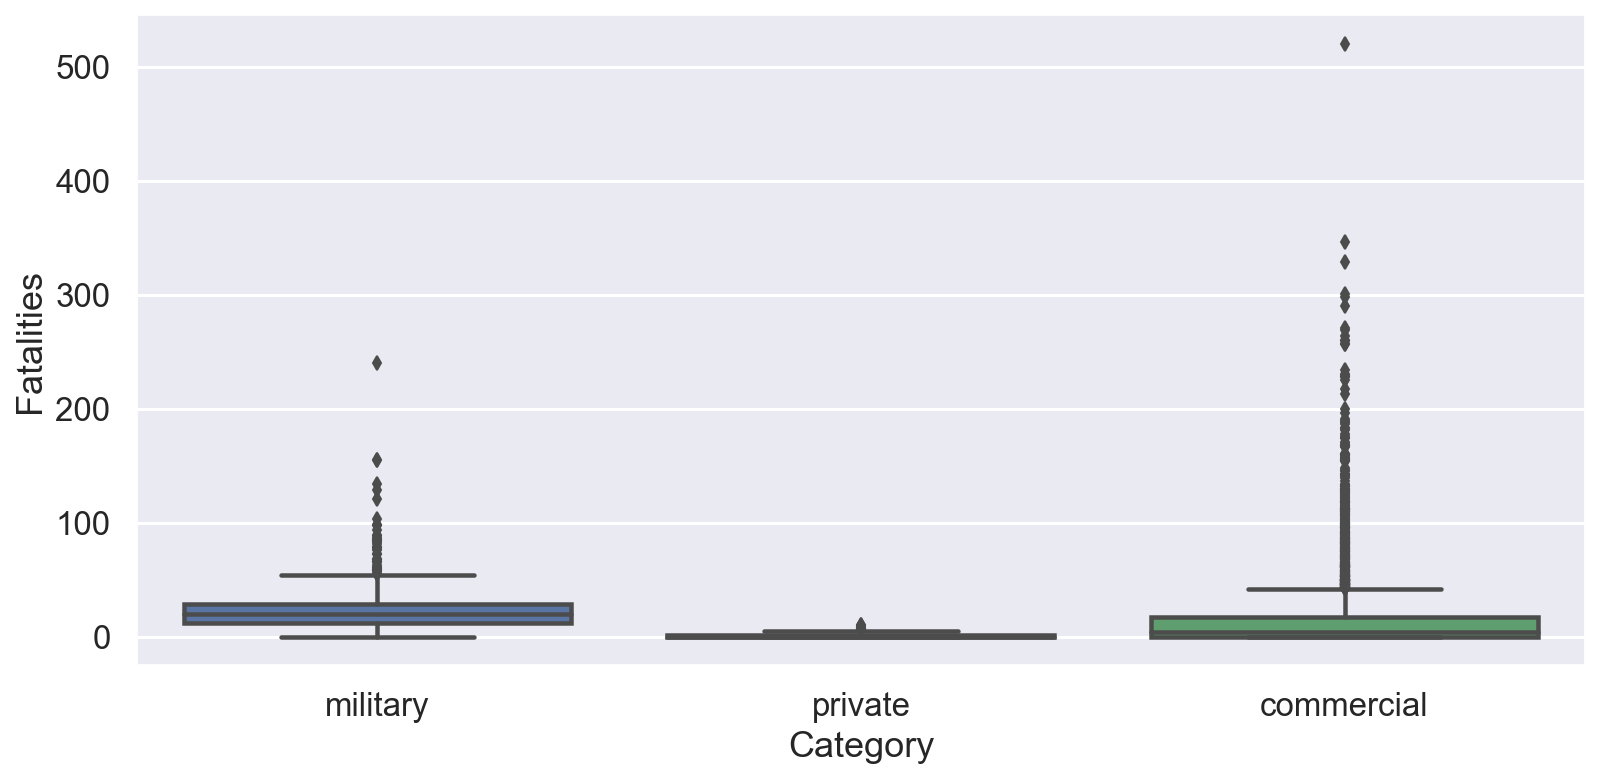

In [213]:
# visualization
sns.boxplot(data = df_operator, x = 'Category', y = 'Fatalities');

Although we already excluded observations that appeared only once, the data is still very right skewed - thus we are going to log transform the `Fatalities`.

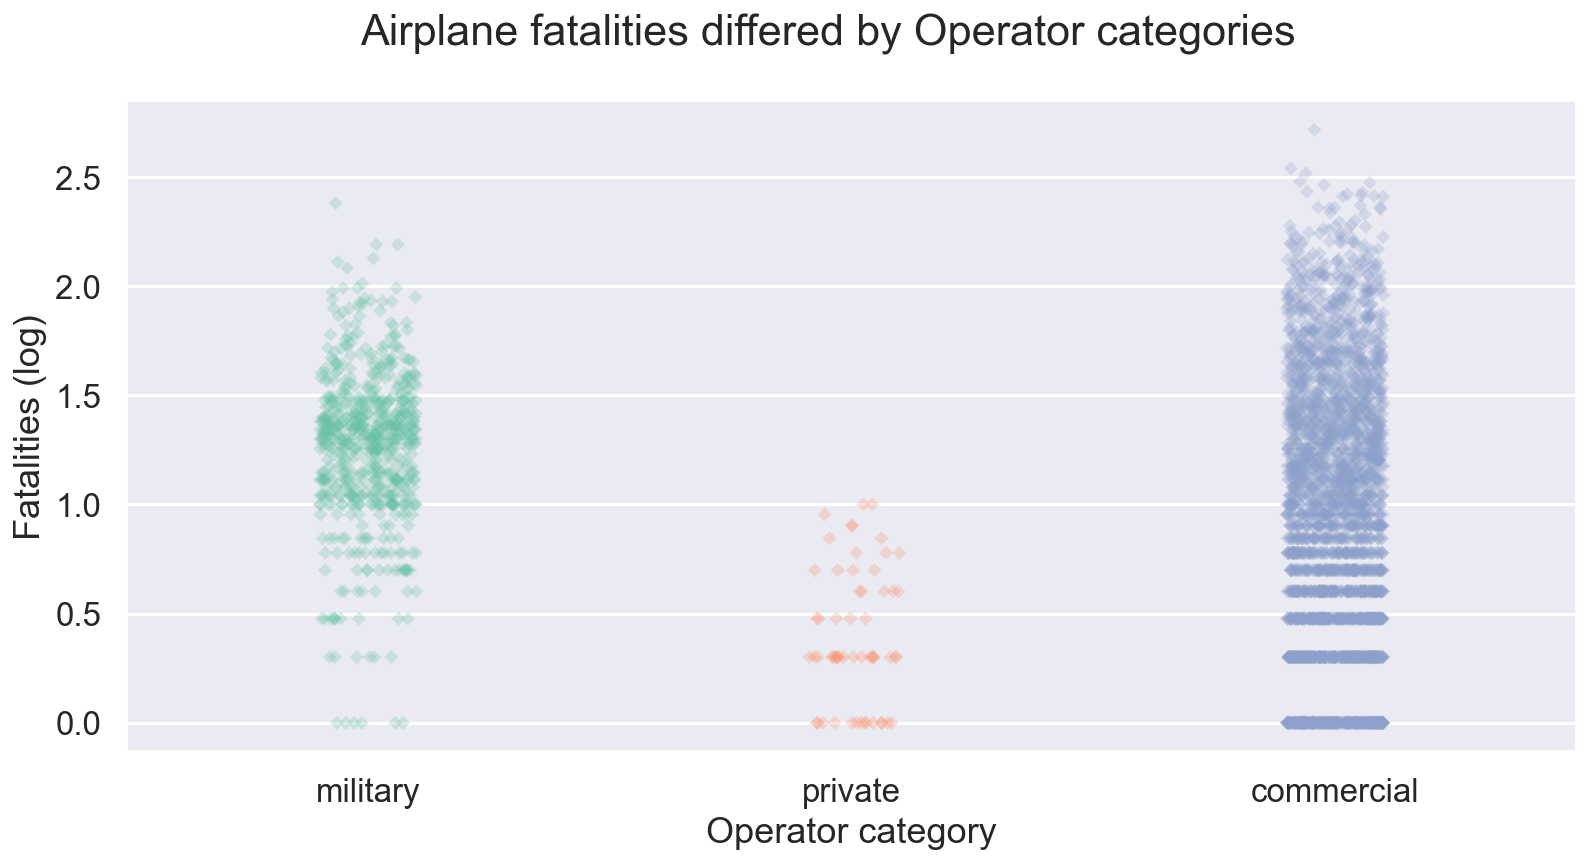

In [214]:
# log transformed fatalities
sns.stripplot(data = df_operator, x = 'Category',
              y = np.log10(df_operator['Fatalities'][df['Fatalities'].notnull()]),
              palette="Set2", size = 5, marker="D", edgecolor="gray", alpha=.25);


plt.suptitle('Airplane fatalities differed by Operator categories')
plt.xlabel('Operator category')
plt.ylabel('Fatalities (log)');

There is some apparant difference between Operator categories, then we are going to perform t-test to statistically access the significance.


In [221]:
model = smf.ols(formula = 'Fatalities ~ Category', data = df_operator)
operator_model = model.fit()

print(operator_model.summary())

                            OLS Regression Results                            
Dep. Variable:             Fatalities   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     39.32
Date:                Fri, 20 May 2022   Prob (F-statistic):           1.15e-17
Time:                        21:09:54   Log-Likelihood:                -23274.
No. Observations:                4778   AIC:                         4.655e+04
Df Residuals:                    4775   BIC:                         4.657e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               16.5937 

> By fit the model, we can see there are significant differences among groups, in which:
   > - `military` operatored flights have highest falaties, followed by `commercial` operators, with `private` operators have lowest fatalities.

## 4.3 Pending data analysis

4.3.1 Generate heat map of the locations of the air crashes

4.3.2 Text processing the keywords of from the `summary` to look for commonality among most fatal airplane accidents.

#### Plans:
1. improve and polish the visualizations, make axis, title, legends more readily for readers.
2. complete data analysis and narrate/interpret more on those statistical results - convey better and clearer messages.
3. Finish heat map and text analysis as the last part of the exploratory analysis. 

All steps should be able to be roughly finished by Final week. 